# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

# Business Understanding

With the given data, these are the question that we would like to find answers to:

1. What are the Income Distribution Groups in the data?
2. In what year,  the people under observation joined the app?
3. What kind of offers are sent to each demographic group?
4. How are the people likely to respond to each offer?
5. Is there a group who completes the offer without viewing it?
6. Who is most likely to complete an offer?
7. What is the money spending trend among all groups under consideration?

### Solution Strategy

To answer the above questions, the main features I have used are **gender**, **age** and **income**. 

These are the steps followed throughout the notebook:
- Import the data sets
- EDA of the data sets
- Clean each data set
- Merge the data on the common columns to form one dataframe
- Drop any columns not required
- Use data plotting to visually answer the question
- Perform any mathematical operations (if required) to display percentages or other figures.
- Discuss the findings under each section so not to overwhelm the reader with all information at the end.

Let's start the analysis by importing the libraries and data from all the sources.

In [1]:
# Importing libraries
import math
import json

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

%matplotlib inline

In [2]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [3]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Exploratory Data Analysis

We start our analysis by separately analysing each of the dataframe and drawing basic plots to better understand the dimensions of the underlying data.

### Portfolio Data 

In [4]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [5]:
# Getting the number of rows and columns in data
portfolio.shape

(10, 6)

In [6]:
# Getting column titles and datatypes alongwith count of non-null entries
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [7]:
# Getting unique type of offers that a customer can be given
portfolio.offer_type.unique()

array(['bogo', 'informational', 'discount'], dtype=object)

#### Key Takeaways

- The portfolio data has 10 rows and 6 columns.
- There are no null values in any row or column.
- The types of offer given to users are BOGO (buy one get one free), Informational and Discount.

### Profile Data

In [8]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [9]:
# Getting the number of rows and columns in data
profile.shape

(17000, 5)

In [10]:
# Getting column titles and datatypes alongwith count of non-null entries
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [11]:
# Getting sun of null values per column
profile.isna().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [12]:
# Finding the unique genders available in our data
profile.gender.unique()

array([None, 'F', 'M', 'O'], dtype=object)

In [13]:
# Counting the entries in each gender type
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

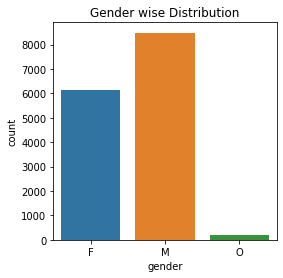

In [14]:
# For a better visual analysis, we plot the distribution of gender on a countplot
plt.figure(figsize=(4 , 4))
sns.countplot(data=profile, x='gender');
plt.title('Gender wise Distribution');

In [15]:
# Analyzing numerical columns for mean and std
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


As seen above, the mean age is 62.5 with the max being 118 years old. Also, the mean income is $65404. 
We now move towards analysing age demographics to see if we can extract any meaningful insights.

In [16]:
profile.age.value_counts().sort_index(ascending=False)

118    2175
101       5
100      12
99        5
98        5
97       13
96        8
95       22
94       33
93       29
92       40
91       47
90       52
89       53
88       64
87       66
86       54
85       70
84       83
83      102
82      105
81      118
80      116
79      117
78      135
77      141
76      155
75      159
74      193
73      209
72      191
71      230
70      252
69      242
68      259
67      317
66      284
65      280
64      311
63      338
62      318
61      309
60      333
59      359
58      408
57      353
56      342
55      350
54      359
53      372
52      351
51      363
50      284
49      321
48      288
47      232
46      212
45      231
44      192
43      215
42      227
41      189
40      202
39      182
38      172
37      197
36      175
35      118
34      147
33      152
32      139
31      113
30      131
29      129
28      137
27      139
26      157
25      136
24      139
23      126
22      131
21      140
20      135
19  

Looks like there are **2175** people who are age **118** using the app. It looks like an odd number in the data. Therefore, we look deep to see if these people have other meaningful information present. 

We filter out the people aged 118 and observe what other data is missing in their records.

In [17]:
profile[profile.age ==118].isna().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

It looks like those people have missing income and gender data, which is an important feature in our analysis. To further explore, we make a histogram of our age and income data to see any other potential outliers.

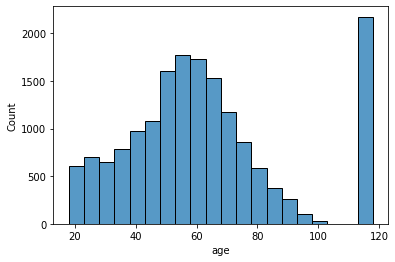

In [18]:
# Making a histogram of the age columns
sns.histplot(data=profile['age'], bins=20);

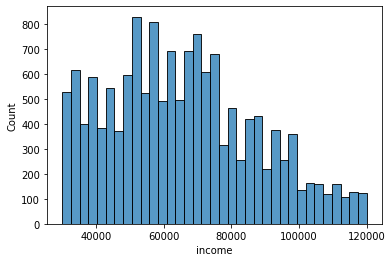

In [19]:
# Analyszing income trends of people using a histogram
sns.histplot(data=profile['income'], bins=35);

#### Key Takeaways

- The profile data has 17000 rows and 5 columns.
- About **2175** records have missing gender and income data, all of which belong to the outlier age group **118**. This would be cleaned later on.
- The average age of our user is 62.5.
- The average income is $65404, with more middle income group and steadily decreasing as the pay increases.

### Transcript Data

In [20]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [21]:
# Getting the number of rows and columns in data
transcript.shape

(306534, 4)

In [22]:
# Getting column titles and datatypes alongwith count of non-null entries
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [23]:
# Looking at the "event" column
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [24]:
# percentage of each event 
transcript.event.value_counts(normalize=True)

transaction        0.453304
offer received     0.248837
offer viewed       0.188315
offer completed    0.109544
Name: event, dtype: float64

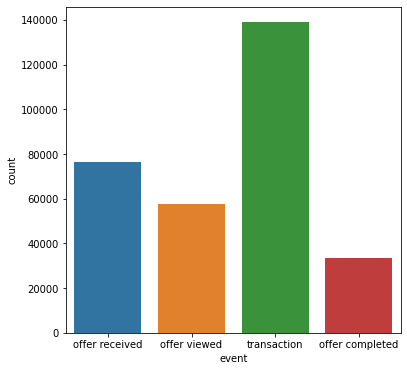

In [25]:
# Analyzing the status of "event" column
plt.figure(figsize=(6 , 6))
sns.countplot(data=transcript, x='event');

In [26]:
# Looking at the record of a random person to see how the transcript data looks like for a random person
transcript[transcript['person'] == '78afa995795e4d85b5d9ceeca43f5fef']

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6
47582,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.89},132
47583,78afa995795e4d85b5d9ceeca43f5fef,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,132
49502,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 17.78},144
53176,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168
85291,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},216
87134,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.67},222
92104,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 29.72},240
141566,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 23.93},378


#### Key Takeaways

- The transcript data has 306534 rows and 4 columns.
- There are no missing values in any of the rows or columns.
- There are three events that may occur regarding an offer i.e. Offer Received, Offer Viewed and Offer Completed.
- Whenever user buys something, the event column has a value "transaction".
- The **value** column contains either the amount of transaction or the offer id with the reward that user recieved in case of completing the offer.
- The **value** columns contains json which would be extracted to separate columns in the later sections.

## Data Cleaning / Wrangling

Now that we have seen all our dataframes in detail, we move towards data cleaning. 

Let's start with **Profile** data by converting the **became_member_on** column to datetime ad separate out membership year for visual analysis.

In [27]:
profile['membership_year'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.year

profile.head()

,gender,age,id,became_member_on,income,membership_year
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,2017
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,2017
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN,2018
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,2017
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN,2017


Moving on to **Transcript** data, we first clean the **value** column by normalizing the json in the column and merging it back with the original data.

In [28]:
# normalizing the json in the "value" column
val_df = pd.json_normalize(transcript['value'])
val_df.head()

,offer id,amount,offer_id,reward
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [29]:
# Looking at datatypes and non null entries in the val_df obtained from "value" column
val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   offer id  134002 non-null  object 
 1   amount    138953 non-null  float64
 2   offer_id  33579 non-null   object 
 3   reward    33579 non-null   float64
dtypes: float64(2), object(2)
memory usage: 9.4+ MB


In [30]:
# checking if both offer_id and offer id are present in a single row
val_df[val_df['offer id'].notnull() & val_df['offer_id'].notnull()]

,offer id,amount,offer_id,reward


In [31]:
# checking when offer_id is present
val_df[val_df['offer_id'].notnull()]

,offer id,amount,offer_id,reward
12658,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,2.0
12672,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0
12679,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0
12692,NaN,NaN,ae264e3637204a6fb9bb56bc8210ddfd,10.0
12697,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0
...,...,...,...,...
306475,NaN,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0
306497,NaN,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0
306506,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0
306509,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0


The columns `offer_id` and `offer id` are same except for the fact that when the offer is received, the column name is marked as `offer id` and when the offer is completed, the data is present under the name `offer_id` along with a `rewards` column. Therefore, for simplicity purposes, we merge these two column into one.

In [32]:
val_df['offer_id'] = val_df['offer_id'].combine_first(val_df['offer id'])

val_df.head()

,offer id,amount,offer_id,reward
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,2906b810c7d4411798c6938adc9daaa5,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,fafdcd668e3743c1bb461111dcafc2a4,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [33]:
val_df.drop('offer id', axis=1, inplace=True)

Since we have merged both the columns into `offer_id`, it is safe to drop the `offer id` column for cleaning purposes. 
The resulting `val_df`  is then concatenated back with the original transcript data. Since we have the data in the `value` column present in separate columns now, we drop that column too.

In [34]:
# concatenating value data back to transcript df but now in separate columns
transcript = pd.concat([transcript, val_df], axis=1)

# dropping the value column
transcript.drop('value', axis=1, inplace=True)

transcript.head()

,person,event,time,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


We finish off by merging all dataframes into one big dataframe for final analysis. 
We start by merging `profile` and `transcript` dataframes for offer information and then finally move towards merging `portfolio` data.

In [35]:
df = transcript.merge(portfolio, left_on='offer_id', right_on='id', how='outer')
df.head()

,person,event,time,amount,offer_id,reward_x,reward_y,channels,difficulty,duration,offer_type,id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,"[web, email, mobile]",5.0,7.0,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,ebe7ef46ea6f4963a7dd49f501b26779,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,"[web, email, mobile]",5.0,7.0,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
2,f082d80f0aac47a99173ba8ef8fc1909,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,"[web, email, mobile]",5.0,7.0,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
3,c0d210398dee4a0895b24444a5fcd1d2,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,"[web, email, mobile]",5.0,7.0,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,57dd18ec5ddc46828afb81ec5977bef2,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,"[web, email, mobile]",5.0,7.0,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9


In [36]:
# dropping the id column as "id" and "offer_id" now have same data.
df.drop('id', axis=1, inplace=True)

In [37]:
# merging all our data into one dataframe "data_df"
data_df = df.merge(profile, left_on='person', right_on='id', how='outer')
data_df.head()

,person,event,time,amount,offer_id,reward_x,reward_y,channels,difficulty,duration,offer_type,gender,age,id,became_member_on,income,membership_year
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,"[web, email, mobile]",5.0,7.0,bogo,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,2017
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,"[web, email, mobile]",5.0,7.0,bogo,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,2017
2,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,"[web, email, mobile]",5.0,7.0,bogo,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,2017
3,78afa995795e4d85b5d9ceeca43f5fef,offer received,504,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN,5.0,"[web, email, mobile, social]",5.0,5.0,bogo,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,2017
4,78afa995795e4d85b5d9ceeca43f5fef,offer completed,510,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,"[web, email, mobile, social]",5.0,5.0,bogo,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,2017


In [38]:
# Getting column titles and datatypes alongwith count of non-null entries
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   person            306534 non-null  object 
 1   event             306534 non-null  object 
 2   time              306534 non-null  int64  
 3   amount            138953 non-null  float64
 4   offer_id          167581 non-null  object 
 5   reward_x          33579 non-null   float64
 6   reward_y          167581 non-null  float64
 7   channels          167581 non-null  object 
 8   difficulty        167581 non-null  float64
 9   duration          167581 non-null  float64
 10  offer_type        167581 non-null  object 
 11  gender            272762 non-null  object 
 12  age               306534 non-null  int64  
 13  id                306534 non-null  object 
 14  became_member_on  306534 non-null  int64  
 15  income            272762 non-null  float64
 16  membership_year   30

In the further analysis, we shall deeply play with `age`, `gender` and `income` data to figure out the demographics of the offer being sent, and what group of people is more likely to complete an offer. 
Therefore, dropping all the other unrelated columns, that we won't be using.

In [39]:
data_df.drop(columns=['id', 'became_member_on', 'channels', 'time', 'reward_x', 'reward_y', 'difficulty', 'duration', 'person', 'offer_id'], axis=1, inplace=True)
data_df.head()

,event,amount,offer_type,gender,age,income,membership_year
0,offer received,NaN,bogo,F,75,100000.0,2017
1,offer viewed,NaN,bogo,F,75,100000.0,2017
2,offer completed,NaN,bogo,F,75,100000.0,2017
3,offer received,NaN,bogo,F,75,100000.0,2017
4,offer completed,NaN,bogo,F,75,100000.0,2017


In [40]:
# Getting the number of rows and columns in data
data_df.shape

(306534, 7)

As we observed during our EDA, that a number of records belonged to age group **118**, which did not have any income or gender information associated with them. Now that we have merged all three dataframes, we drop all the rows of data belonging to those people to exclude them from our analysis to prevent skewing our results in any other direction.

In [41]:
data_df.drop(data_df[data_df['age'] == 118].index, inplace=True)

In [42]:
data_df.shape

(272762, 7)

In [43]:
data_df.describe()

,amount,age,income,membership_year
count,123957.000000,272762.000000,272762.000000,272762.000000
mean,13.996325,53.840696,64337.000755,2016.457435
std,31.749420,17.551337,21243.762941,1.218663
min,0.050000,18.000000,30000.000000,2013.000000
25%,3.660000,41.000000,48000.000000,2016.000000
50%,10.800000,55.000000,62000.000000,2017.000000
75%,19.130000,66.000000,78000.000000,2017.000000
max,1062.280000,101.000000,120000.000000,2018.000000


We see that since dropping, our mean age has dropped from **62.5** to **53.8** where as there is negligible difference in the mean income.

#### Binning our Continuous variables

In order to discover set of patterns in continuous variables, we bin our continuous variables i.e. age and income into categorical variables.

The division for age groups is as follows:
- 18 to 30  &#8594; Youth
- 31 to 50  &#8594; Adult
- 51 to 75  &#8594; Senior
- 76 to 110 &#8594; Old

In [44]:
bins = [17, 30, 50, 75, 110]
category = ['Youth', 'Adult', 'Senior', 'Old']
data_df['age_group'] = pd.cut(data_df['age'], bins, labels=category)

We now bin our income into 3 groups, the division of which is as follows:
- 0 to 40,000 &#8594; Low
- 40,001 to 80,000 &#8594; Middle
- 80,001 to 130,000 &#8594; High

In [45]:
bins = [0, 40000, 80000, 130000]
category = ['Low', 'Middle', 'High']
data_df['income_group'] = pd.cut(data_df['income'], bins, labels=category)

data_df.head()

,event,amount,offer_type,gender,age,income,membership_year,age_group,income_group
0,offer received,NaN,bogo,F,75,100000.0,2017,Senior,High
1,offer viewed,NaN,bogo,F,75,100000.0,2017,Senior,High
2,offer completed,NaN,bogo,F,75,100000.0,2017,Senior,High
3,offer received,NaN,bogo,F,75,100000.0,2017,Senior,High
4,offer completed,NaN,bogo,F,75,100000.0,2017,Senior,High


## Finding the Answers

Now we move towards our final step i.e. finding the answers pertaining to the given data.
First we write a generic function that will be used to create different graphs for our data.

For each of the question, we will draw three graphs for each of our considered feature i.e. 
1. gender
2. age
3. income


In [46]:
def plot_feature_distribution(data, x=None, hue=None, title=None, xlabel=None):
    """
    Plots given feature sent to each type of population demographic
    
    :param data: dataframe
    :param hue: list
    :param x: string
    :param title: string
    :return: None
    """
    
    plt.figure(figsize=(5 , 5))
    ax = sns.countplot(data=data, x=x, hue=hue)
    ax.set(xlabel=xlabel, ylabel='Number of People', title=title)
    plt.show()

### What are the Income Distribution Groups in the data?

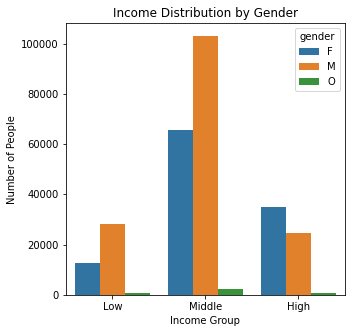

In [47]:
plot_feature_distribution(data=data_df, x='income_group', hue= 'gender', title='Income Distribution by Gender', xlabel='Income Group')

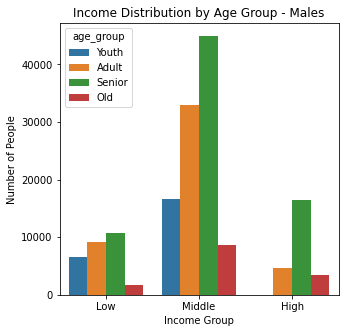

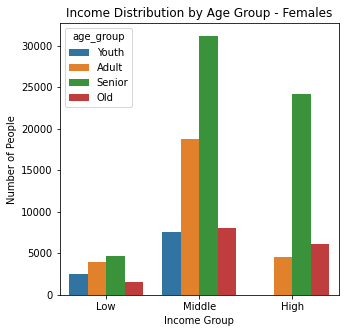

In [48]:
plot_feature_distribution(data=data_df[data_df.gender=="M"], x='income_group', hue= 'age_group', title='Income Distribution by Age Group - Males', xlabel='Income Group')
plot_feature_distribution(data=data_df[data_df.gender=="F"], x='income_group', hue= 'age_group', title='Income Distribution by Age Group - Females', xlabel='Income Group')

#### Key Takeaways
- Males are higher in number for both low and middle income groups but females are in larger quantity for the high income groups.
- The number of Senior High income women in larger than senior high income men, indicating that with a high pay women are more likely to sign up to such apps.


### In what year, the people under observation joined the app?

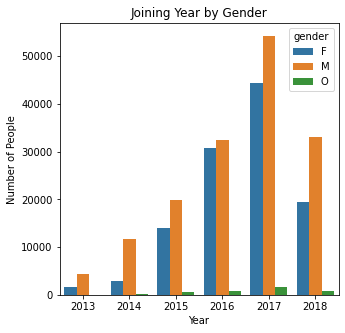

In [49]:
plot_feature_distribution(data=data_df, x='membership_year', hue= 'gender', title='Joining Year by Gender', xlabel='Year')

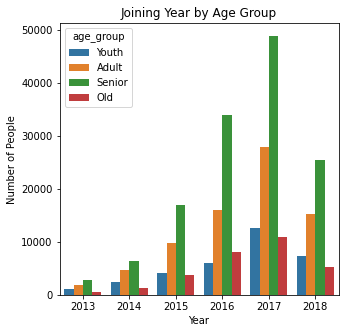

In [50]:
plot_feature_distribution(data=data_df, x='membership_year', hue= 'age_group', title='Joining Year by Age Group', xlabel='Year')

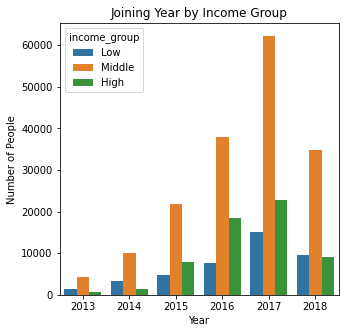

In [51]:
plot_feature_distribution(data=data_df, x='membership_year', hue= 'income_group', title='Joining Year by Income Group', xlabel='Year')

#### Key Takeaways
- The data ranges from 2013 to 2018.
- For all features, the most people joined the app in 2017 followed by 2016 and then 2018.
- Most people who signed up in app every year identify as Male.
- By age, the most common group was Senior i.e. between ages 51 to 75.
- Regarding income, middle income people appear most in each year.


### What kind of offers are sent to each demographic group?

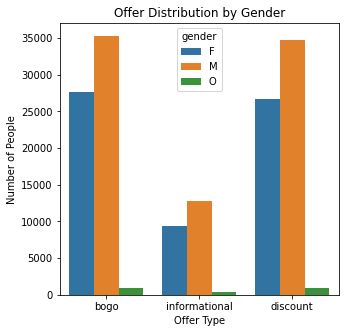

In [52]:
plot_feature_distribution(data=data_df, x='offer_type', hue= 'gender', title='Offer Distribution by Gender', xlabel='Offer Type')

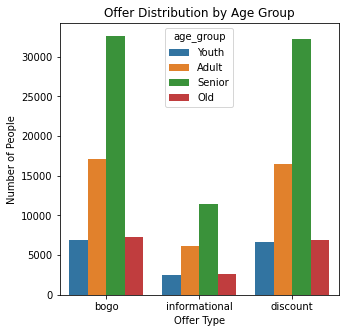

In [53]:
plot_feature_distribution(data=data_df, x='offer_type', hue= 'age_group', title='Offer Distribution by Age Group', xlabel='Offer Type')

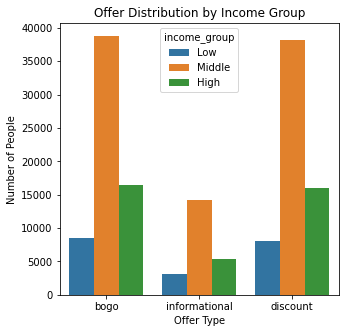

In [54]:
plot_feature_distribution(data=data_df, x='offer_type', hue= 'income_group', title='Offer Distribution by Income Group', xlabel='Offer Type')

#### Key Takeaways
- As evident from above graphs, the BOGO offers are most sent followed closely by discount offers.
- Due to larger population size, if we just look at numbers, males receive more offers than females, seniors than all others age groups and middle income people than lower or high income groups.

### How are the people likely to respond to each offer?

We now want to analyze the trend on people who actually viewed and then completed an offer. 
For this we will filter out the rows where a **transaction** event took place. We will also drop the rows with **informational** offer as it is just to be viewed and has no way of completion.

#### **NOTE**

For this question, we plot separate graphs for males and females, since this is habit based and may actually display different results depending upon gender.

In [55]:
# Verifying that informational offers never have a offer completed status
data_df.query('offer_type == "informational" & event == "offer completed"')

,event,amount,offer_type,gender,age,income,membership_year,age_group,income_group


In [56]:
offer_df = data_df.query('event != "transaction" & offer_type != "informational"')

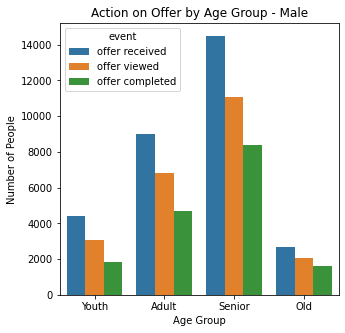

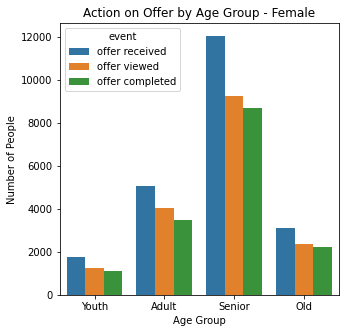

In [57]:
plot_feature_distribution(data=offer_df[offer_df.gender == 'M'], x='age_group', hue= 'event', title='Action on Offer by Age Group - Male', xlabel='Age Group')
plot_feature_distribution(data=offer_df[offer_df.gender == 'F'], x='age_group', hue= 'event', title='Action on Offer by Age Group - Female', xlabel='Age Group')

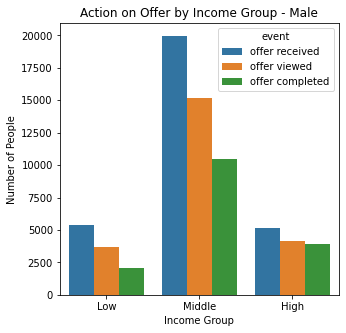

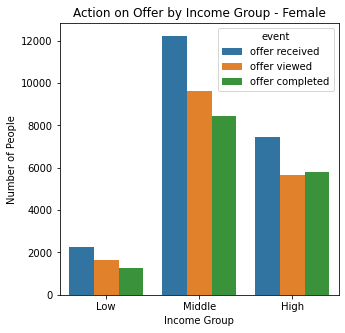

In [58]:
plot_feature_distribution(data=offer_df[offer_df.gender == 'M'], x='income_group', hue= 'event', title='Action on Offer by Income Group - Male', xlabel='Income Group')
plot_feature_distribution(data=offer_df[offer_df.gender == 'F'], x='income_group', hue= 'event', title='Action on Offer by Income Group - Female', xlabel='Income Group')

#### Key Takeaways
- For all age groups, we observe, that males are more likely to view an offer, and then complete it, which is indicated by the difference in the bars for "offer viewed" and "offer completed". For females, this difference in size of bars is smaller, indicating that women are more likely to complete an offer without actually viewing it.
- This difference gets even more prominent when we visualize by income groups. The "high" income group of females completes an offer even before viewing it. 
- The high paying male group also exhibits similar characteristics, but on our current bins, they still view more offers than completions.

The above points lead us to analyze the income and offer completion trend in detail. Therefore, we analyze the high income group separately to see if there is any thing else we can figure out.

### Is there a group who completes the offer without viewing it?

Since our analysis already catered for the income range > 80,000, we move the analysis deeper and tried various values to maximize % difference between offer viewed and completed. After much pondering and evaluating, the amount to view the high income group behaviour is set to be at 100,000.

We now find the count of high paying males and females and then try to find the percentage of those who completed an offer and those who viewed it. As per business perspective, the difference group is the one that will buy products regardless of an offer.

#### % of viewed and completed offers by High income Males

In [59]:
# Finding % of completed offers by Males with income > 100000. 
total = offer_df.query('gender == "M" & income > 100000').shape[0]
viewed_count = offer_df.query('gender == "M" & income > 100000 & event =="offer viewed"').shape[0]
completed_count = offer_df.query('gender == "M" & income > 100000 & event =="offer completed"').shape[0]

print('% of men with income > 100000, vieweing an offer = {}'.format(viewed_count/total))
print('% of men with income > 100000, completing an offer = {}'.format(completed_count/total))

% of men with income > 100000, vieweing an offer = 0.27427184466019416
% of men with income > 100000, completing an offer = 0.32142857142857145


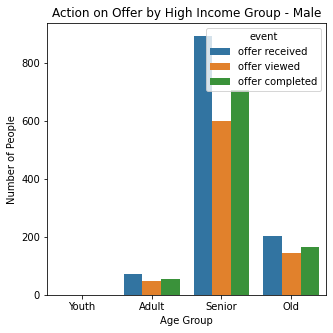

In [60]:
plot_feature_distribution(data=offer_df.query('gender == "M" & income > 100000'), x='age_group', hue='event', title='Action on Offer by High Income Group - Male', xlabel='Age Group')

#### % of viewed and completed offers by High income Females

In [61]:
# Finding % of completed offers by Females with income > 100000
total = offer_df.query('gender == "F" & income > 100000').shape[0]
viewed_count = offer_df.query('gender == "F" & income > 100000 & event =="offer viewed"').shape[0]
completed_count = offer_df.query('gender == "F" & income > 100000 & event =="offer completed"').shape[0]

print('% of women with income > 100000, vieweing an offer = {}'.format(viewed_count/total))
print('% of women with income > 100000, completing an offer = {}'.format(completed_count/total))

% of women with income > 100000, vieweing an offer = 0.2811522633744856
% of women with income > 100000, completing an offer = 0.31209876543209875


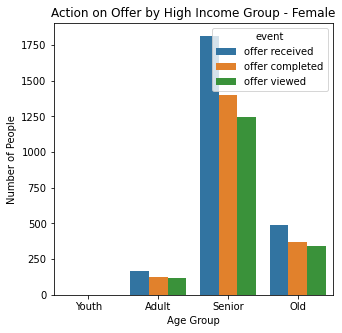

In [62]:
plot_feature_distribution(data=offer_df.query('gender == "F" & income > 100000'), x='age_group', hue='event', title='Action on Offer by High Income Group - Female', xlabel='Age Group')

#### Key Takeaways
- For males, with income > 100,000, **27%** viewed the offers sent to them, whereas **32%** completed the offer.
- For females, with income > 100,000, **28%** viewed the offers and about **31%** completed the offer sent.
- We can see that the number of high paying women using the app is much larger than the males counterpart.
- Most of the offers completed were in Senior age group.
- However, since there are no high income youth, all the other age groups had more people completing the offers than viewing.
- The above finding leads us to the conclusion that for highly paid people specifically people who earn more than 100,000 dollars, sending them offers does not has much of an impact as most of them are buying anyway.

We dive further into detail of who actually completed an offer to better separate out groups to send offers to.

### Who is most likely to complete an offer?

For this analysis, we only keep in consideration the `offer completed` event to see what percent of demographics actually spent money completing offers, to send them more offers for business promotions.

In [63]:
offer_df = offer_df[offer_df.event == 'offer completed']

In [64]:
# Finding percentage of each gender likely to complete offers
total_received_offers_males = data_df.query('gender == "M" & offer_type != "informational" & event == "offer received"').shape[0]
total_received_offers_females = data_df.query('gender == "F" & offer_type != "informational" & event == "offer received"').shape[0]
completed_offers_counts = offer_df.gender.value_counts()

print('Ratio of offers completed by each gender group to the offers received by that group:')
print('MALES : {}'.format(completed_offers_counts['M']/total_received_offers_males))
print('FEMALES: {}'.format(completed_offers_counts['F']/total_received_offers_females))


Ratio of offers completed by each gender group to the offers received by that group:
MALES : 0.5387736404685557
FEMALES: 0.7061319463454695


In [65]:
# percentae of each income group likely to complete offers
total_received_offers_low = data_df.query('income_group == "Low" & offer_type != "informational" & event == "offer received"').shape[0]
total_received_offers_middle = data_df.query('income_group == "Middle" & offer_type != "informational" & event == "offer received"').shape[0]
total_received_offers_high = data_df.query('income_group == "High" & offer_type != "informational" & event == "offer received"').shape[0]

completed_offers_counts = offer_df.income_group.value_counts()
print('Ratio of offers completed by each income group to the offers received by that group')
print('LOW INCOME GROUP : {}'.format(completed_offers_counts['Low']/total_received_offers_low))
print('MIDDLE INCOME GROUP : {}'.format(completed_offers_counts['Middle']/total_received_offers_middle))
print('HIGH INCOME GROUP : {}'.format(completed_offers_counts['High']/total_received_offers_high))


Ratio of offers completed by each income group to the offers received by that group
LOW INCOME GROUP : 0.4337442218798151
MIDDLE INCOME GROUP : 0.5903171441703693
HIGH INCOME GROUP : 0.7670214431053373


The below graphs represent a break down of what kind of offers are more likely to be completed by each of our demographic groups under consideration. Note that we removed the **informational** offer type from these as they do not require any spending and hence are not considered an offer to be completed.

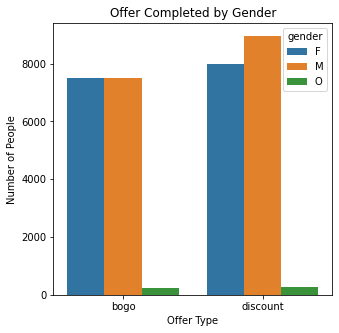

In [66]:
plot_feature_distribution(data=offer_df, x='offer_type', hue= 'gender', title='Offer Completed by Gender', xlabel='Offer Type')

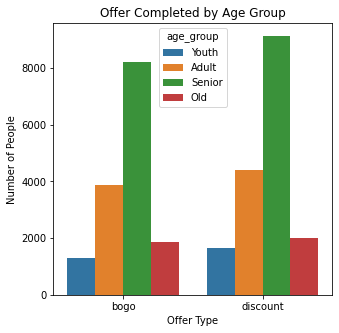

In [67]:
plot_feature_distribution(data=offer_df, x='offer_type', hue= 'age_group', title='Offer Completed by Age Group', xlabel='Offer Type')

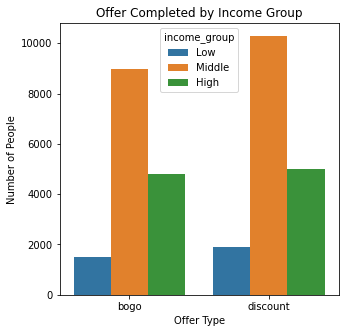

In [68]:
plot_feature_distribution(data=offer_df, x='offer_type', hue= 'income_group', title='Offer Completed by Income Group', xlabel='Offer Type')

#### Key Takeaways
- Of all the offers sent to males, 53% of them were completed.
- The female group however completed around 71% of all the offers making them the high spending group.
- Considering the income groups, the High income group completed 77% of the offers but as we have already analysed, many of them were unintentionally completed so this is not a group we should be targeting.
- Middle Income group completed around 59 and Low income group completed about 43% of the offers.
- Athough bogo offers comprise of most offers sent, the more completed offers are comprised of discount offers, as can be seen from above three graphs.


### What is the money spending trend among all groups under consideration?

Here we exclude the "Other" gender type and try to visualize the total mean amount spent by people falling in each of the demographic groups. 

In [69]:
spending_groups = data_df[data_df['gender'] != 'O'].groupby(['gender', 'age_group', 'income_group'])['amount'].mean().unstack()
spending_groups

income_group           Low     Middle       High
gender age_group                                
F      Youth      7.929251  12.216525        NaN
       Adult      7.291425  14.384808  26.915305
       Senior     7.503029  16.075643  28.763828
       Old        8.032796  14.973397  28.050670
M      Youth      5.630277   7.508602        NaN
       Adult      5.749909   9.958494  27.314657
       Senior     5.389785  11.530586  28.506858
       Old        4.854296  11.654222  30.107047

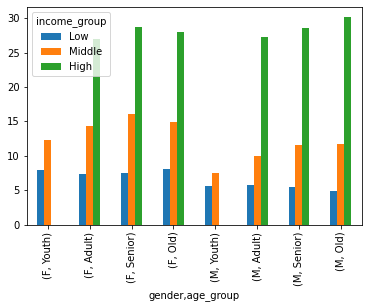

In [70]:
spending_groups.plot.bar()
plt.show()

#### Key Takeaways
- There are no "Youth" groups in high income category for both males and females.
- Females are likely to spend more than males.
- Only High Income Old Males spent more than their female counterparts.
- An interesting observation is that Women tend to spend less as they grow from Senior to Old age group. This can be seen for both, middle and high, income groups.
- Men tend to spend more as they make this transition. This can be seen for both middle and high income groups in the above visualization.


## Conclusion

This data was very fun to play with. Although in the start, it seemed overwhelming because there was just so much that could be explored. However for this project, this notebook is limited to analyzing only `age`, `gender` and `income` of all the customer to figure out what should be the target audience of future offers.

### Major Findings:

Here are the most important findings of the analysis:
- The fact I found most interesting that drove to other findings was that the number of highly paid women was much larger than highly paid men. 
- Very High Income groups do not care about offers. They are likely to spend money whether given an offer or not. Therefore, they should not be a target audience for offers.
- Since the ratio of women completing offers is far higher than males, they should be sent more offers, although the current trend is otherwise.
- Most people using the app belong to Middle Income group, and they have a very good rate of completing offers. They seem a good candidate for future offers.
- Though BOGO offers were sent more often, people mostly completed the discount offers.
- The strangest thing is the shift of spending habit in women as they grow old. womenwho sepdn more than men in all ages, especially in adult and senior age, seem to spend less as they grow older, whereas men seem to spend more as they grow into Old age group. This seemed like an anomaly in the start, and I had to spend quite some time looking if there was a mistake.

### Suggestions:
- Since Youth is very under represented, and it is a demigraphic that is here to stay for a long time. Special offers should be sent to Youth to engage them more and even attract new customers.
- Highly paid people should not be send offers, because they will spend anyway.
- Low Income people are also fairly less in quantity. Offers that require small amount to complete should be sent to these groups for a loyal customer base buildup.

### Future Improvements

This analysis can be extended in the future to include the time taken by the users to complete an offer. This will help in finding the group that responds quickly to offers. Also, considering the channels used to send offers might also prove an important insight as to which offers are most likely to be completed.
Finally, a model can be trained that uses the spending trends and other demographic information to predict what offer to send to a person with certain properties, that is most likely to be completed.